# Fine-tuning VGG Network.

In this hometask you'll need to fine-tune VGG network for dogs classification (the same dataset as in practical seminar).

## Loading the data

In [ ]:
# this cell downloads zip archive with data
! wget "https://www.dropbox.com/s/r11z0ugf2mezxvi/dogs.zip?dl=0" -O dogs.zip

--2025-02-26 21:16:33--  https://www.dropbox.com/s/r11z0ugf2mezxvi/dogs.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/cgwxt4jlpesmb9oq9s19f/dogs.zip?rlkey=ysuiqksb7i8ewm117m5e7lqxh&dl=0 [following]
--2025-02-26 21:16:33--  https://www.dropbox.com/scl/fi/cgwxt4jlpesmb9oq9s19f/dogs.zip?rlkey=ysuiqksb7i8ewm117m5e7lqxh&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc68eca015f48960c8c001b89ee6.dl.dropboxusercontent.com/cd/0/inline/Ck7TWYZ4rj4eV_GiZ6GfXxplmW3mAHdr2JkBw1hHNyTNfxSG03PP44EfK7OasODMvDRjybefVHMcs9VgVGPiHMO-TdS8DxCc--OHt9TbF7H84eOoTF95udYyfEees-BzeQEZ6dGmIBPsI2OxbRwMXjMK/file# [following]
--2025-02-26 21:16:34--  https://uc68eca015f48960c8c001b89ee6.dl.dropboxusercontent.com/cd/0/inlin

In [ ]:
# this cell extract the archive. You'll now have "dogs" folder in colab
! unzip -qq dogs.zip

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import random
from torch.optim.lr_scheduler import StepLR

In [ ]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Task 1

Your task is to fine-tune [VGG11 ](https://pytorch.org/vision/0.20/models/generated/torchvision.models.vgg11.html) network from torchvision for the task of dogs breed classification. Your task is to tune the model so that it has the best test accuracy possible. You are not allowed to use any other pretrained model except this and any other data except given.

What you can do:
- **Preprocess and augment data**. Note the following: there is a difference between ordinary data preprocessing (as we did in the practical session) and augmentation. Preprocessing usually refers to the way all the data (train and test) is processed before feeding into the network; augmentation is a technique used to populate training set of samples. Augmentation should only be used on training data, but not on validation and test data. You can read more about augmentation [here](https://d2l.ai/chapter_computer-vision/image-augmentation.html). Also think about what kind of image augmentations are suitable for the given task, e.g. would that be beneficial to flip images vertically in our case?
- **Change/remove/add layers to the network**. You can change layers of the pre-trained VGG11. Note, however, that newly added layers should not be pre-trained. You are allowed to add any layers, e.g. conv, fc, dropout, batchnorm
- **Tune hyperparameters**, e.g. batch size, learning rate, etc.

If X is your score on test set, them your task score is calculated as follows: min(0.95, (X-0.75))*5

#Датасееееет

In [ ]:
'''
dataset = datasets.ImageFolder(root='/content/dogs/train', transform=transforms.Compose([transforms.ToTensor(),  transforms.Resize((224, 224))]))
dataloader = DataLoader(dataset, batch_size=32)

mean = torch.zeros(3)
std = torch.zeros(3)
for images, _ in dataloader:
    mean += images.mean((0, 2, 3))
    std += images.std((0, 2, 3))

mean /= len(dataloader)
std /= len(dataloader)

print("Mean:", mean)
print("Std:", std)
'''

Mean: tensor([0.5255, 0.4894, 0.4217])
Std: tensor([0.2651, 0.2608, 0.2681])


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.08, saturation=0.1, hue=0.05),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5255, 0.4894, 0.4217], std=[0.2651, 0.2608, 0.2681])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4623, 0.4075, 0.3524], std=[0.2453, 0.2229, 0.2549])
])

In [ ]:
train_data = datasets.ImageFolder(root='/content/dogs/train', transform=train_transform)
val_data = datasets.ImageFolder(root='/content/dogs/valid', transform=test_transform)
test_data = datasets.ImageFolder(root='/content/dogs/test', transform=test_transform)

In [ ]:
len(train_data.classes) #Количество классов:

70

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True) #пробовала разный размер батча: 64, 32, 16. Лучшим 16 оказался
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

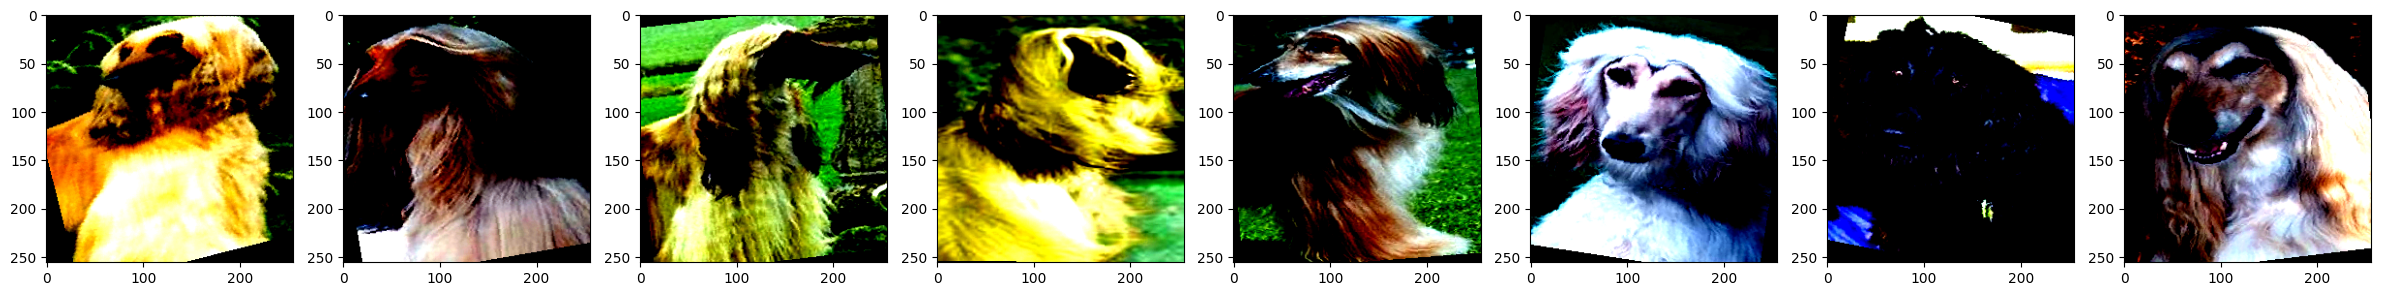

In [ ]:
f, axes= plt.subplots(1, 8, figsize=(30,5))

for i, axis in enumerate(axes):
    img, label = train_data[i]
    img = np.transpose(img, (1, 2, 0))
    axes[i].imshow(img)
plt.show()

#Моделька и обучение туда-сюда

In [ ]:
from torchvision import models

In [ ]:
model = models.vgg11(weights='IMAGENET1K_V1')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
'''
model.features = nn.Sequential(
    *list(model.features.children()),  # Сохраняем оригинальные слои VGG11
    nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Добавляем новый сверточный слой, чтоб моделька лучше выделала признаки (ммм, ну, точнее, выделяла более сложные признаки, чем раньше)
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
'''
for param in model.features.parameters():
    param.requires_grad = False

# Переделываем classifier (полносвязные слои)
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 3072),
    nn.BatchNorm1d(3072),
    nn.ReLU(inplace=True),
    nn.Dropout(0.7),
    nn.Linear(3072, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 70)
    #nn.LeakyReLU(),
    #nn.Linear(70, 70)
)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
'''
model.features = nn.Sequential(
    *list(model.features.children()),  # Сохраняем оригинальные слои VGG11
    nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Добавляем новый сверточный слой, чтоб моделька лучше выделала признаки (ммм, ну, точнее, выделяла более сложные признаки, чем раньше)
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
'''

for param in model.features.parameters():
    param.requires_grad = False

# Переделываем classifier (полносвязные слои)
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 3072),
    nn.BatchNorm1d(3072),
    nn.ReLU(inplace=True),
    nn.Dropout(0.6),
    nn.Linear(3072, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.6),
    nn.Linear(512, 70)
    #nn.LeakyReLU(),
    #nn.Linear(70, 70)
)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
train_acc_scores = []
val_acc_scores = []

best_val_acc = 0.0
best_model_path = 'best_model.pth'
model = model.to(device)
num_epochs = 16

scheduler = StepLR(optimizer, step_size=4, gamma=0.2)  #Каждые 4 эпохи лр уменьшается в 5 раз

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_true = []
    train_pred = []

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)



        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())

    train_acc = accuracy_score(train_true, train_pred)
    train_losses.append(running_loss / len(train_loader))
    train_acc_scores.append(train_acc)

    scheduler.step()
    model.eval()
    val_running_loss = 0.0
    val_true = []
    val_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())

    val_acc = accuracy_score(val_true, val_pred)
    val_losses.append(val_running_loss / len(val_loader))
    val_acc_scores.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'New best model saved with accuracy: {best_val_acc:.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train accuracy: {train_acc:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val accuracy: {val_acc:.4f}')

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.8400
Epoch [1/16], Train Loss: 2.1120, Train accuracy: 0.4364, Val Loss: 0.7970, Val accuracy: 0.8400


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.8686
Epoch [2/16], Train Loss: 1.1641, Train accuracy: 0.6540, Val Loss: 0.6837, Val accuracy: 0.8686


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.8914
Epoch [3/16], Train Loss: 0.9432, Train accuracy: 0.7197, Val Loss: 0.6214, Val accuracy: 0.8914


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [4/16], Train Loss: 0.8199, Train accuracy: 0.7469, Val Loss: 0.6570, Val accuracy: 0.8814


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.9100
Epoch [5/16], Train Loss: 0.6655, Train accuracy: 0.7915, Val Loss: 0.6266, Val accuracy: 0.9100


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.9214
Epoch [6/16], Train Loss: 0.5679, Train accuracy: 0.8192, Val Loss: 0.6367, Val accuracy: 0.9214


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [7/16], Train Loss: 0.5293, Train accuracy: 0.8291, Val Loss: 0.6098, Val accuracy: 0.9171


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.9257
Epoch [8/16], Train Loss: 0.4730, Train accuracy: 0.8536, Val Loss: 0.6242, Val accuracy: 0.9257


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.9271
Epoch [9/16], Train Loss: 0.4466, Train accuracy: 0.8608, Val Loss: 0.6188, Val accuracy: 0.9271


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.9286
Epoch [10/16], Train Loss: 0.4220, Train accuracy: 0.8714, Val Loss: 0.6108, Val accuracy: 0.9286


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

New best model saved with accuracy: 0.9329
Epoch [11/16], Train Loss: 0.4219, Train accuracy: 0.8696, Val Loss: 0.6029, Val accuracy: 0.9329


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [12/16], Train Loss: 0.3992, Train accuracy: 0.8808, Val Loss: 0.6039, Val accuracy: 0.9300


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [13/16], Train Loss: 0.4123, Train accuracy: 0.8710, Val Loss: 0.6249, Val accuracy: 0.9271


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [14/16], Train Loss: 0.4000, Train accuracy: 0.8747, Val Loss: 0.6237, Val accuracy: 0.9300


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [15/16], Train Loss: 0.3978, Train accuracy: 0.8704, Val Loss: 0.6032, Val accuracy: 0.9300


  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [16/16], Train Loss: 0.3876, Train accuracy: 0.8816, Val Loss: 0.6172, Val accuracy: 0.9257


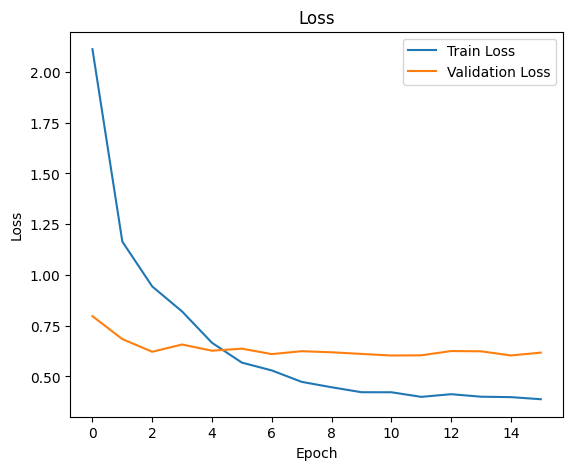

In [ ]:
def model_plot(train_losses, val_losses):
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

model_plot(train_losses, val_losses)

In [ ]:
def evaluate(model, loader, criterion, device):
    '''
    args:
        model - our neural network model
        loader — structure which yields batches of test data
        criterion - loss function from `torch.nn` module
    '''
    model.to(device)
    model.eval()
    losses = []
    y_pred_list = []
    y_true_list = []

    for X_batch, y_batch in loader:
        with torch.no_grad():
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            losses.append(loss.item())

        y_pred = torch.argmax(y_pred, dim=1).tolist()
        y_pred_list.extend(y_pred)
        y_true_list.extend(y_batch.tolist())
    accuracy = accuracy_score(y_true_list, y_pred_list)

    return np.mean(losses), accuracy

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pth'))

<ipython-input-40-ed4a627f4e77>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


<All keys matched successfully>

In [ ]:
evaluate(model, test_loader, criterion, device)

(0.16904157918708568, 0.9528571428571428)